
<img src="Datrition-1.jpg" alt="Smiley face" height="150" width="150" align="right">


# Capstone Project - Datrition 
   ###### Team:  Omar Alharbi - Mansour Aljuaid  - Sumaiah Alsadhan 

# Problem Statement 

---

# Model

## Importing Libraries¶

In [1]:
import cv2
import os
from skimage import color, data, io, measure
from skimage.filters import threshold_otsu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tqdm import tqdm
import glob
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
mpl.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi']= 300 #UPDATED
plt.rc("savefig", dpi=300) #UPDATED

In [4]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = False

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "right-to-left":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [5]:
def f(y):
    # Defining a kernel length
    global horizontal_lines_img, verticle_lines_img, kernel
    kernel_length = np.array(img).shape[1]//y

    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    ###kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=1)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=1)
    cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=1)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=1)
    ###plt.subplot(1, 2, 1)  # 2 rows, 2 columns, 1st subplot = top left
    ###plt.imshow(verticle_lines_img);
    ###plt.axis('off')

    ###plt.subplot(1, 2, 2)  # 2 rows, 2 columns, 2nd subplot = top right
    plt.imshow(horizontal_lines_img);
    plt.axis('off')

In [6]:
#  images.append(mpimg.imread(img_path))
#     print("Processing Image", len(images))

---

## Images Pre-Processing 
### Processing from img Folder, then saving them in another folder named : 'img_result'

100%|██████████| 24/24 [18:25<00:00, 80.29s/it]


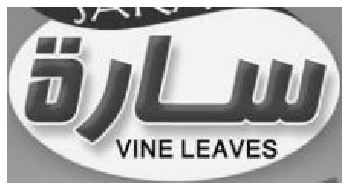

In [7]:
images = []
counter = 1
for img_path in tqdm(glob.glob('img/*.jpg')):
    
    img = cv2.imread(img_path,0)
    (thresh, img_bin) = cv2.threshold(img, 240, 255,cv2.THRESH_OTSU| cv2.ADAPTIVE_THRESH_GAUSSIAN_C) # UPDATE
    img_bin = 255-img_bin
    f(255)
    alpha = 1.0
    beta =  0.9 - alpha #UPDATE
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.5)
    #img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 230,255, cv2.THRESH_OTSU| cv2.ADAPTIVE_THRESH_GAUSSIAN_C) # UPDATE
    plt.axis('off')
    plt.imshow(img_final_bin)
#     images.append(mpimg.imread(img_path))
    # Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) #UPDATE

    # Sort all the contours by top to bottom.
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    idx = 1
    
    for c in (contours):
        # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        
# If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
        if (w > 160 and h > 80) and w < 2.5 *h:
            idx += 3
            new_img = img[y:y+h, x:x+w]
            #plt.subplot(2,3, idx)
            plt.imshow(new_img)
            plt.axis('off')
            #cv2.imwrite('./th/')
            #path = './th/'
            #plt.savefig(f'./img_result/label{counter}.jpg',dpi=300)
            #cv2.imwrite(os.path.join(path , 'label'+str(num)+'.jpg'), new_img)
            #cv2.imwrite(os.path.join(path , 'f', new_img))
            file_n = img_path.split('_')[-1].split('.')[0]
            plt.savefig(f'./img_result/{file_n}_Nutritions_{counter}.jpg',dpi=300) #UPDATED
            counter+=1
            #cv2.waitKey(0)
    #break

In [8]:
new_img

array([[139, 139, 139, ..., 139, 139, 139],
       [140, 140, 140, ..., 140, 140, 140],
       [140, 140, 140, ..., 140, 140, 140],
       ...,
       [156, 156, 156, ..., 145, 155, 154],
       [156, 156, 156, ..., 140, 155, 156],
       [157, 157, 157, ..., 136, 150, 152]], dtype=uint8)

---

## Extracting text from Nutrition lables
    OCR (pytesseract) and Open CV

### Importing Packages & Libraries:

In [9]:
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
import os
import glob
import re
import sys
import cv2
import post_process

### Applicatopn of OCR on images saved at 'img_result'

In [10]:
def label_Recognizer(path):
    import re
    import os
    from matplotlib import pyplot 
    files = []
    for  r,d, f in os.walk(path):
        print(f)
        print(d)
        print(r)
        for file in f:
            files.append(os.path.join(file))
    p = re.compile('[0-9]+.jpg')
    all_result = []
    for f in files:
        #print(f)
     #   out_dict = end_to_end.end_to_end(f'{path}\{f}')
        #-----------------

        for file in glob.glob('img_result/*.jpg'):
            bw = cv2.imread(file, 0)

        # Apply adaptive thresholding to images | @Suma Not Required already applied in image processing.
#             thresh = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#                 cv2.THRESH_BINARY, 11, 2)

        # Get text recognition from thresholded images
            output = pytesseract.image_to_string(Image.fromarray(bw))

            fileName = p.findall(file)[0]
            print ("Proccessing " + fileName)
            #outFileName = fileName[0:len(fileName)-4]
            # Get default text recognition 
            #output = pytesseract.image_to_string(Image.open(file))
            x = post_process.post_process(output)
            print("\n Completed Labels for:", '\n', fileName, '\n', output)
            all_result.append(x)
            x['product_id']=file
        result = []
        for i in all_result:
            if len(i) == 0:
                pass
            else:
                result.append(i)
        return result

In [11]:
n = label_Recognizer('img_result/')

['1_Nutritions_29.jpg', '6_Nutritions_75.jpg', '5_Nutritions_101.jpg', '8_Nutritions_115.jpg', '12_Nutritions_69.jpg', '12_Nutritions_68.jpg', '81_Nutritions_134.jpg', '8_Nutritions_114.jpg', '5_Nutritions_100.jpg', '6_Nutritions_74.jpg', '9_Nutritions_126.jpg', '1_Nutritions_28.jpg', '9_Nutritions_124.jpg', '6_Nutritions_76.jpg', '5_Nutritions_102.jpg', '8_Nutritions_116.jpg', '8_Nutritions_117.jpg', '5_Nutritions_103.jpg', '6_Nutritions_77.jpg', '73_Nutritions_23.jpg', '9_Nutritions_119.jpg', '9_Nutritions_125.jpg', '9_Nutritions_121.jpg', '80_Nutritions_129.jpg', '82_Nutritions_137.jpg', '73_Nutritions_27.jpg', '6_Nutritions_73.jpg', '7_Nutritions_49.jpg', '5_Nutritions_107.jpg', '.DS_Store', '8_Nutritions_113.jpg', '81_Nutritions_133.jpg', '81_Nutritions_132.jpg', '8_Nutritions_112.jpg', '5_Nutritions_106.jpg', '7_Nutritions_48.jpg', '6_Nutritions_72.jpg', '73_Nutritions_26.jpg', '80_Nutritions_128.jpg', '9_Nutritions_120.jpg', '9_Nutritions_122.jpg', '73_Nutritions_24.jpg', '5_Nut

Proccessing 100.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 100.jpg 
 
Proccessing 74.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 74.jpg 
 
Proccessing 126.jpg
[('CholesterolOmg ss', '0', 0), ('SCE A ONG a ee siwaced eed', '0', 1), ('Total Carbohydrat', '7g 3', 2), ('eee FIO FOG es ne bec', '0', 3), ('_jotalSugar', '7', 4), ('__Includes', '0gAdded Sugars 0', 5), ('Protein', '09 | 0', 6), ('VitaminAQmg  VitaminC Omg', '0', 7), ('CTE ON ane na', '0', 8), ('lronOmg ee', '0', 9), ('Potassium Omg', '0', 10)]



[('CholesterolOmg ss', '0', 0), ('Total Carbohydrat', '7g 3', 2), ('_jotalSugar', '7', 4), ('Protein', '09 | 0', 6), ('Potassium Omg', '0', 10)]



[('CholesterolOmg ss', '0', 0), ('Total Carbohydrat', '7g 3', 2), ('_jotalSugar', '7', 4), ('Protein', '09 | 0', 6), ('Potassium Omg', '0', 10)]



[('Potassium', '0', 5), ('Total Carbohydrate', '7g 3', 2), ('Protein', '09 | 0', 4)]



[('Total Carbohydrate', '7g 3', 2)]




 Completed Labels for: 
 126.jpg

Proccessing 49.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 49.jpg 
 
Proccessing 107.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 107.jpg 
 
Proccessing 113.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 113.jpg 
 
Proccessing 133.jpg
[('Butter', '250', 0), ('£250 Jota) quls Ce Gaal! AL', '8 $55 |jast', 1), ('M5 %', '62 (Jebel) qua Cpa) Jobe 5135 iti Sal', 2), ('Arnie Ch g US Lis rr gl ', '1 be cole cual %19 94', 3), ('£100/F39.5:Axsciall ¢ gd all', '¢ gd all', 4)]



[]



[]



[]



[]




 Completed Labels for: 
 133.jpg 
 Delamere Dairy Lightly Spreadable Goats
Butter 250g
£250 Jota) quls Ce Gaal! ALt8 $55 |jasts

M5 % 62 (Jebel) qua Cpa) Jobe 5135 iti Sal]
Arnie Ch g US Lis rr gl %1 be cole cual %19 94)
£100/F39.5:Axsciall ¢ gd all

Stated) Astea!) ¢ Lis}
Proccessing 132.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 132.jpg 
 Ezz)
Z\O[OjOOS OS
s100b
Proccessing 112.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 

Proccessing 22.jpg
[('Total Fat', '1.639 2.50', 0), ('Saturated Fat', '0. 24g 1.2', 1), ('Trans Fat Og', '0%', 2), ('Cholesterol', '10mg a V', 3), ('Sodium', '190mg 7.91%', 4), ('Total Carbohydrate', '25.129 G&£37', 5), ('Sugars', '11.51', 6), ('Protein', '1.2', 7), ('*Perent Daily Valued are basedon', '42,000 calorie die', 8)]



[('Total Fat', '1.639 2.50', 0), ('Saturated Fat', '0. 24g 1.2', 1), ('Trans Fat Og', '0%', 2), ('Cholesterol', '10mg a V', 3), ('Sodium', '190mg 7.91%', 4), ('Total Carbohydrate', '25.129 G&£37', 5), ('Sugars', '11.51', 6), ('Protein', '1.2', 7)]



[('Total Fat', '1.639 2.50', 0), ('Saturated Fat', '0. 24g 1.2', 1), ('Trans Fat Og', '0%', 2), ('Cholesterol', '10mg a V', 3), ('Sodium', '190mg 7.91%', 4), ('Total Carbohydrate', '25.129 G&£37', 5), ('Sugars', '11.51', 6), ('Protein', '1.2', 7)]



[('Total Fat', '1.639 2.50', 1), ('Saturated Fat', '0. 24g 1.2', 2), ('Trans Fat', '0%', 3), ('Cholesterol', '10mg a V', 4), ('Sodium', '190mg 7.91%', 5), ('Total Ca

Proccessing 38.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 38.jpg 
 
Proccessing 147.jpg
[('serving size', '1 oz (28g! About 21 pieces', 0), ('Calories', '160 Calories from fat 100', 1), ('Saturated Fatl', '6g9 | Ov', 2), ('Cholesterol Omg', '0', 3), ('Sodium', '250g 10', 4), ('Total Carbohydrate', '13g «6', 5), ('Dietray Fiber less than ig', '2', 6), ('Sugars', '0', 7)]



[('serving size', '1 oz (28g! About 21 pieces', 0), ('Calories', '160 Calories from fat 100', 1), ('Saturated Fatl', '6g9 | Ov', 2), ('Cholesterol Omg', '0', 3), ('Sodium', '250g 10', 4), ('Total Carbohydrate', '13g «6', 5), ('Dietray Fiber less than ig', '2', 6), ('Sugars', '0', 7)]



[('serving size', '1 oz (28g! About 21 pieces', 0), ('Calories', '160 Calories from fat 100', 1), ('Saturated Fatl', '6g9 | Ov', 2), ('Cholesterol Omg', '0', 3), ('Sodium', '250g 10', 4), ('Total Carbohydrate', '13g «6', 5), ('Dietray Fiber less than ig', '2', 6), ('Sugars', '0', 7)]



[('Serving Size', '1 oz (28g! A

Proccessing 90.jpg
[('preeeel rare = sl = Jay', '2 SiligSal', 0), ('Chalories', '0 PRE ep ie Pear RUS eRe ren [Peary', 1), ('are Ly:', '0% 012 69 89 500 - 05018 12 53', 2), ('Ree ure} re . me es UT ey el mee', '1 eel ee ete e', 3), ('Total Carb.', '0g ey ee eee ee eee Le eet eee ee ee', 4), ('Berit or nears aan', '2007/1636 Pac) Gross Wt : 14 K', 5), ('Aer Netwt ', '12K', 6), ('O28', '(78 Bua ep eA an i', 7)]



[('Chalories', '0 PRE ep ie Pear RUS eRe ren [Peary', 1), ('Total Carb.', '0g ey ee eee ee eee Le eet eee ee ee', 4), ('Berit or nears aan', '2007/1636 Pac) Gross Wt : 14 K', 5)]



[('Chalories', '0 PRE ep ie Pear RUS eRe ren [Peary', 1), ('Total Carb.', '0g ey ee eee ee eee Le eet eee ee ee', 4), ('Berit or nears aan', '2007/1636 Pac) Gross Wt : 14 K', 5)]



[('Calories', '0 PRE ep ie Pear RUS eRe ren [Peary', 1), ('Total Fat', '0g ey ee eee ee eee Le eet eee ee ee', 2)]



[('Calories', '0 PRE ep ie Pear RUS eRe ren [Peary', 1), ('Total Fat', '0g ey ee eee ee eee Le eet eee

Proccessing 98.jpg
[('or as part of q cel', '125', 0), ('inmeal!', '7 sices Per “o', 1)]



[]



[]



[]



[]




 Completed Labels for: 
 98.jpg 
 alad, on o cheese !
or as part of q cel 125g

inmeal! 7 sices Per “oh

nae
Proccessing 156.jpg
[('Serv Size', '1 ty aa ats PASTEURIZED P', 0)]



[('Serv Size', '1 ty aa ats PASTEURIZED P', 0)]



[('Serv Size', '1 ty aa ats PASTEURIZED P', 0)]



[('Serving Size', '1 ty aa ats PASTEURIZED P', 1)]



[('Serving Size', '1 ty aa ats PASTEURIZED P', 1)]




 Completed Labels for: 
 156.jpg 
 Nutrition Fa is] MOREDIENT So
Serv Size 1 ty aa ats PASTEURIZED PA

MILK, CHEESE CUIURE,
SALT, ENZYMES
Proccessing 82.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 82.jpg 
 
Proccessing 10.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 10.jpg 
 Nutritional information:

ak
Proccessing 12.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 12.jpg 
 
Proccessing 80.jpg
[]



[]



[]



[]



[]




 Completed Labels for

Proccessing 138.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 138.jpg 
 
Proccessing 52.jpg
[('Serving Size ', '2', 0), ('Serving Per Container:', '24pc', 1), ('‘item —~—s~Pe', '100g.~2=~=*é“‘«‘“‘NSRRVMGSC™', 2), ('“Energy .', '365KJ 18', 3), ('Protein Og', '0', 4), ('Fat Og', '0', 5), ('Carbohydrate', '92.29 31', 6), ('Sodium', '24mq 0', 7)]



[('Serving Size ', '2', 0), ('Serving Per Container:', '24pc', 1), ('“Energy .', '365KJ 18', 3), ('Protein Og', '0', 4), ('Carbohydrate', '92.29 31', 6), ('Sodium', '24mq 0', 7)]



[('Sugars', '2', 0), ('Serving Per Container:', '24pc', 1), ('“Energy .', '365KJ 18', 3), ('Protein Og', '0', 4), ('Carbohydrate', '92.29 31', 6), ('Sodium', '24mq 0', 7)]



[('Energy', '365KJ 18', 3), ('Sodium', '24mq 0', 6), ('Total Carbohydrate', '92.29 31', 5), ('Sugars', '2', 1), ('Protein', '0', 4)]



[('Energy', '365KJ 18', 3), ('Total Carbohydrate', '92.29 31', 5), ('Sugars', '2', 1), ('Protein', '0', 4)]




 Completed Labels for: 
 52.jpg 


Proccessing 55.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 55.jpg 
 
Proccessing 42.jpg
[]



[]



[]



[]



[]




 Completed Labels for: 
 42.jpg 
 
Proccessing 44.jpg
[('Siew CAigSyirsplaio lp sga', 'CAigSyirsplaio lp sga', 0), ('ey big agh Ml a', '1', 1), ('SNTAYEEAGG a poglS', '9 Bd', 2), ('www.', '4matrade.com:', 3), ('NDUGyl Cagle i pe', '2S ph! Hay', 4), ('slo sgui ', '9in', 5), ('Serving Size', '3-5 olves! 16g', 6), ('‘Servings per container About:', '2', 7), ('Calories', '30 Calories from fat 2', 8), ('‘Monmiansaturated Fat', '5', 9), ('eer', '700gme', 10), ('sete.', '350gm', 11), ('723 ge Product of Faynt', 'ge Product of Faynt', 12)]



[('Siew CAigSyirsplaio lp sga', 'CAigSyirsplaio lp sga', 0), ('Serving Size', '3-5 olves! 16g', 6), ('‘Servings per container About:', '2', 7), ('Calories', '30 Calories from fat 2', 8), ('‘Monmiansaturated Fat', '5', 9), ('723 ge Product of Faynt', 'ge Product of Faynt', 12)]



[('Siew CAigSyirsplaio lp sga', 'CAigSyirsp

In [12]:
len(n)

167

### DataFrame Creation from Raw Text

In [13]:
dx = pd.DataFrame(n)

In [14]:
dx.product_id.unique()

array(['img_result/1_Nutritions_29.jpg', 'img_result/6_Nutritions_75.jpg',
       'img_result/5_Nutritions_101.jpg',
       'img_result/8_Nutritions_115.jpg',
       'img_result/12_Nutritions_69.jpg',
       'img_result/12_Nutritions_68.jpg',
       'img_result/81_Nutritions_134.jpg',
       'img_result/8_Nutritions_114.jpg',
       'img_result/5_Nutritions_100.jpg',
       'img_result/6_Nutritions_74.jpg',
       'img_result/9_Nutritions_126.jpg',
       'img_result/1_Nutritions_28.jpg',
       'img_result/9_Nutritions_124.jpg',
       'img_result/6_Nutritions_76.jpg',
       'img_result/5_Nutritions_102.jpg',
       'img_result/8_Nutritions_116.jpg',
       'img_result/8_Nutritions_117.jpg',
       'img_result/5_Nutritions_103.jpg',
       'img_result/6_Nutritions_77.jpg',
       'img_result/73_Nutritions_23.jpg',
       'img_result/9_Nutritions_119.jpg',
       'img_result/9_Nutritions_125.jpg',
       'img_result/9_Nutritions_121.jpg',
       'img_result/80_Nutritions_129.jpg',
   

In [15]:
dx.product_id = dx.product_id.apply(lambda x:x.replace('img_result/',''))

In [16]:
dx.head()

,product_id,Energy,Serving Size,Calories,Saturated Fat,Total Carbohydrate,Dietary Fiber,Sugars,Protein,Sodium,Total Fat,Trans Fat,Cholesterol
0,1_Nutritions_29.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6_Nutritions_75.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5_Nutritions_101.jpg,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8_Nutritions_115.jpg,NaN,28,15,1,16,1,210,NaN,NaN,NaN,NaN,NaN
4,12_Nutritions_69.jpg,NaN,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
dx.set_index(keys='product_id').dropna(how='all')

,Energy,Serving Size,Calories,Saturated Fat,Total Carbohydrate,Dietary Fiber,Sugars,Protein,Sodium,Total Fat,Trans Fat,Cholesterol
product_id,,,,,,,,,,,,
5_Nutritions_101.jpg,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8_Nutritions_115.jpg,NaN,28,15,1,16,1,210,NaN,NaN,NaN,NaN,NaN
12_Nutritions_69.jpg,NaN,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8_Nutritions_114.jpg,NaN,28,15,NaN,16,4,NaN,,NaN,NaN,NaN,NaN
9_Nutritions_126.jpg,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8_Nutritions_116.jpg,NaN,NaN,NaN,NaN,14,NaN,NaN,NaN,210,NaN,NaN,NaN
9_Nutritions_125.jpg,NaN,1,3,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
82_Nutritions_137.jpg,NaN,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73_Nutritions_24.jpg,NaN,22,100,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN


In [18]:
dx.product_id.unique()

array(['1_Nutritions_29.jpg', '6_Nutritions_75.jpg',
       '5_Nutritions_101.jpg', '8_Nutritions_115.jpg',
       '12_Nutritions_69.jpg', '12_Nutritions_68.jpg',
       '81_Nutritions_134.jpg', '8_Nutritions_114.jpg',
       '5_Nutritions_100.jpg', '6_Nutritions_74.jpg',
       '9_Nutritions_126.jpg', '1_Nutritions_28.jpg',
       '9_Nutritions_124.jpg', '6_Nutritions_76.jpg',
       '5_Nutritions_102.jpg', '8_Nutritions_116.jpg',
       '8_Nutritions_117.jpg', '5_Nutritions_103.jpg',
       '6_Nutritions_77.jpg', '73_Nutritions_23.jpg',
       '9_Nutritions_119.jpg', '9_Nutritions_125.jpg',
       '9_Nutritions_121.jpg', '80_Nutritions_129.jpg',
       '82_Nutritions_137.jpg', '73_Nutritions_27.jpg',
       '6_Nutritions_73.jpg', '7_Nutritions_49.jpg',
       '5_Nutritions_107.jpg', '8_Nutritions_113.jpg',
       '81_Nutritions_133.jpg', '81_Nutritions_132.jpg',
       '8_Nutritions_112.jpg', '5_Nutritions_106.jpg',
       '7_Nutritions_48.jpg', '6_Nutritions_72.jpg',
       '73_Nutr

In [19]:
dx.shape

(167, 13)

#### Creating A Dataframe from Raw Text (Try 1)

In [21]:
test = n[0].split('\n')

In [ ]:
#df_test = pd.DataFrame(test)

In [ ]:
#df_test[0][19]

In [ ]:
df_test

In [ ]:
df_test = df_test.rename(columns={0:'data'})

In [ ]:
df_test[df_test['data'].str.contains('Serving')]

In [ ]:
df_test['data'].str.extract('(\d+?[Aa-zZ]+)')

# Visualization of Nutrition facts 

In [80]:
raw_data = {'image': ['img_result/74_label12.jpg'],
            'Calories':[120],
        'Cholesterol': [10],
        'Protein': [70],
        'Saturated Fat':[20],
        'Sodium': [190],
           'Sugars':[11.51],
          'Total Carbohydrate':[25.12],
           'Total Fat':[15],
          'Trans Fat':[33] }
df = pd.DataFrame(raw_data, columns = ['image','Calories', 'Cholesterol', 'Protein','Saturated Fat', 'Sodium','Sugars',
                                      'Total Carbohydrate','Total Fat','Trans Fat'])
df

,image,Calories,Cholesterol,Protein,Saturated Fat,Sodium,Sugars,Total Carbohydrate,Total Fat,Trans Fat
0,img_result/74_label12.jpg,120,10,70,20,190,11.51,25.12,15,33


In [81]:
raw_data = {'image': ['img_result/74_label12.jpg'],
        'Cholesterol': [10],
        'Protein': [1.2],
        'Sodium': [190],
           'Sugars':[11.51]}
dt = pd.DataFrame(raw_data, columns = ['image', 'Cholesterol', 'Protein', 'Sodium','Sugars'])
dt

,image,Cholesterol,Protein,Sodium,Sugars
0,img_result/74_label12.jpg,10,1.2,190,11.51


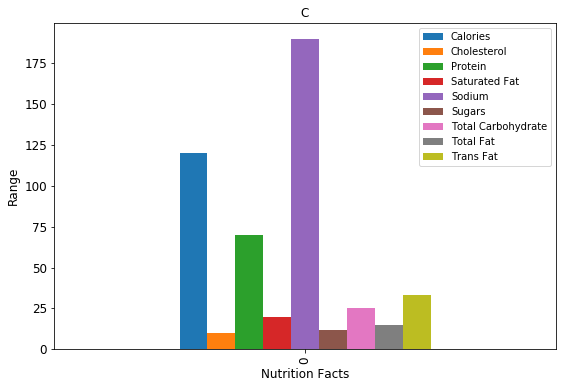

In [85]:
import matplotlib.pyplot as plt
ax = df.plot(kind='bar', title ="C", figsize=(9, 6), fontsize=12)
ax.set_xlabel("Nutrition Facts", fontsize=12)
ax.set_ylabel("Range", fontsize=12)
plt.show();

In [46]:
import plotly.graph_objects as go

labels = ['Cholesterol', 'sugar', 'Protein','Sodium']

# pull is given as a fraction of the pie radius
fig = go.Figure(data=[go.Pie(labels=labels,  pull=[0, 0, 0.2, 0])])
fig.show()

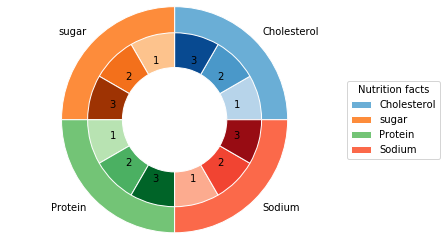

In [29]:
group_names=['Cholesterol', 'sugar', 'Protein','Sodium']
group_size=[9,9,9,9]
subgroup_names=['1', '2', '3', '1', '2','3', '1', '2', '3', '1', '2','3']
subgroup_size=[3,3,3,3,3,3,3,3,3,3,3,3]
 
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Oranges, plt.cm.Greens, plt.cm.Reds]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.5), b(0.5), c(0.5),d(0.5)] )
plt.setp( mypie, width=0.6, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.3), a(0.6), a(0.9), b(0.3), b(0.6), b(0.9), c(0.3), c(0.6), c(0.9), d(0.3),d(0.6),d(0.9)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
ax.legend( group_names,
          title="Nutrition facts",
          loc="center left",
          bbox_to_anchor=(1,0, 0.7, 1))
# show it
plt.show()

## Reference_codes

### All_Labels:

In [ ]:

#sys.path.append('/usr/local/lib/python2.7/site-packages')


def writeFile(directory, fileName, content):
    outFile = open('outputs/' + directory + '/' + fileName + '.txt', 'w')
    outFile.write(content)
    outFile.close()

# Setup regex for stripping file names
p = re.compile('[0-9]+.jpg')
    
# Use images in the labels directory
for file in glob.glob('../labels/*.jpg'):
    fileName = p.findall(file)[0]
    print ("Proccessing " + fileName)
    outFileName = fileName[0:len(fileName)-4]
    # Get default text recognition 
    output = pytesseract.image_to_string(Image.open(file))
    #print(output)

    # Write default text output to 'outputs/default' directory
    writeFile('default', outFileName, output)

    # Open image as black and white
    bw = cv2.imread(file, 0)

    # Apply adaptive thresholding to images
    thresh = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY, 11, 2)

    # Get text recognition from thresholded images
    output = pytesseract.image_to_string(Image.fromarray(bw))
    writeFile('bw', outFileName, output)

    break

In [ ]:
def label_Recognizer(path):
    import re
#    import end_to_end
    import os
    from matplotlib import pyplot 
    files = []
    # r=root, d=directories, f = files
    for  r,d, f in os.walk(path):
        for file in f:
            files.append(os.path.join(file))
    p = re.compile('[0-9]+.jpg')
    all_result = []
    for f in files:
        print(f)
     #   out_dict = end_to_end.end_to_end(f'{path}\{f}')
        #-----------------
        for file in glob.glob('./img_result/*.jpg'):
            fileName = p.findall(file)[0]
            print ("Proccessing " + fileName)
            outFileName = fileName[0:len(fileName)-4]
            # Get default text recognition 
            output = pytesseract.image_to_string(Image.open(file))
            print("/n", output)
            all_result.append(output)

            # Write default text output to 'outputs/default' directory
#             writeFile('default', outFileName, output)

#             # Open image as black and white
#             bw = cv2.imread(file, 0)

#             # Apply adaptive thresholding to images
#             thresh = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#                     cv2.THRESH_BINARY, 11, 2)

#             # Get text recognition from thresholded images
#             output = pytesseract.image_to_string(Image.fromarray(bw))
                

#         #-----------------
# #         print('This is out_dict type', type(out_dict))
# #         print(f.replace(r'.jpg',''))
# #         out_dict['Image_id']=f.replace(r'.jpg','')
#             all_result.append(output)
            
#         break

    df = pd.DataFrame(all_result)
    df = pd.DataFrame(columns=['Image_id','Nutrient', 'Amount', 'Unit', 'Serving Size','Serving Size Unit','Language'])
    df_long = df.melt(id_vars=['Serving Size','Image_id'])
    Units = {'Calories': 'Kcal',
        'Energy': 'kJ',
        'Total Fat': 'g',
        'Saturated Fat': 'g',
        'Trans Fat': 'g',
        'Poly Fat': 'g',
        'Mono Fat': 'g',
        'Cholesterol': 'mg',
        'Sodium': 'mg',
        'Potassium': 'g',
        'Total Carbohydrate': 'g',
        'Dietary Fiber': 'g',
        'Sugars': 'g',
        'Protein': 'g'}
    df_long['Serving Size Unit']= 'g'
    df_long.columns = ['Serving Size','Image_id','Nutrient','Amount','Serving Size Unit']
    df_long['Unit'] = [Units [x] for x in df_long['Nutrient']]
    df_long['Language'] = 'English'
    Final_Outcome = df_long[['Image_id','Nutrient', 'Amount', 'Unit', 'Serving Size','Serving Size Unit','Language']]
    Final_Outcome.to_excel('DSI-V-Abdulrahman.xlsx', index=False)
    return Final_Outcome

In [ ]:
basename = os.path.basename("./img_result")
label_impath = impath.replace(basename, 'tmp_' + basename)
# label_impath = impath.lower().replace('.jpg', 'label_tmp.jpg')
cv2.imwrite(label_impath, label_im)

start = timer()
# Apply Tesseract to image
output = apply_tesseract(label_impath, demo=demo)
#        print ("\n")
output = pytesseract.image_to_string(label_impath,lang='eng')
#     print(arabic)

end = timer()
print('OCR time: %2f' % (end-start))
os.remove(label_impath)

start = timer()
ocr_label = post_process(output, demo=demo)
print(ocr_label)

end = timer()
print('Post process time: %2f' % (end-start))

if show:
    draw_image(label_im, 'Transformed label: %s' % impath)

return ocr_label

### image view

In [1]:
io.imshow('./test_result.png')

### Text with Tesseract - codes:

In [ ]:

import pytesseract
from PIL import Image, ImageEnhance, ImageFilter

im = Image.open("test_result.png") # the second one 
im = im.filter(ImageFilter.MedianFilter())
enhancer = ImageEnhance.Contrast(im)
im = enhancer.enhance(22)
im = im.convert('1')
im.save('test2.jpg')

text = pytesseract.image_to_string(Image.open('test2.jpg'))
print(text)

#### Method 2

In [ ]:
# A seconde way to extract text - OCR 
import os
import tempfile
import subprocess

def ocr(path):
    temp = tempfile.NamedTemporaryFile(delete=False)

    process = subprocess.Popen(['tesseract', path, temp.name], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    process.communicate()

    with open(temp.name + '.txt', 'r') as handle:
        contents = handle.read()

    os.remove(temp.name + '.txt')
    os.remove(temp.name)

    return contents

str = ocr('test_result.png')
print(str)

In [ ]:
img = cv2.imread('img/product_5.jpg',0)

In [ ]:
idx = 0
boxes = []
for c in contours:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)
    if (w > 80 and h > 20) and w > 3*h:
        idx += 1
        boxes.append(img[y:y+h, x:x+w])
# If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
    if (w > 80 and h > 20) and w > 3*h:
        idx += 1
        boxes.append(img[y:y+h, x:x+w])
        idx = 0
boxes = []
for c in contours:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)
    if (w > 80 and h > 20) and w > 3*h:
        idx += 1
        boxes.append(img[y:y+h, x:x+w])
# If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
    if (w > 80 and h > 20) and w > 3*h:
        idx += 1
        boxes.append(img[y:y+h, x:x+w])

In [ ]:
boxes